<h1 align="center">Machine Learning for NLP</h1>
    <h2 align="center">Spam Detection Using K-Nearest Neighbors</h2>
    <h3 align="center">Zahra Amini</h3>
<div style="width: 100%; text-align: center;">
    <table>
        <tr>
            <td>
                <a class="link" href="https://t.me/Zahraamini_ai">Telegram</a><br>
                <a class="link" href="https://www.linkedin.com/in/zahraamini-ai/">LinkedIn</a><br>
                <a class="link" href="https://www.youtube.com/@AcademyHobot">YouTube</a><br>
            </td>
            <td>
                <a class="link" href="https://github.com/aminizahra">GitHub</a><br>
                <a class="link" href="https://www.kaggle.com/aminizahra">Kaggle</a><br>
                <a class="link" href="https://www.instagram.com/zahraamini_ai/">Instagram</a><br>
            </td>
        </tr>
    </table>
</div>

# import Libraries

In [31]:
import pandas as pd
import numpy as np
import re
import string

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, roc_curve
from imblearn.over_sampling import SMOTE

import joblib

import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [29]:
# pip install imblearn

In [33]:
# مسیر فایل دیتاست
file_path = 'SMS Spam Dataset/spam.csv'

# خواندن دیتاست
data = pd.read_csv(file_path, encoding='latin-1')

# نگه داشتن ستون‌های مورد نیاز
data = data[['v1', 'v2']]
data.columns = ['label', 'text']

# تبدیل برچسب‌ها به اعداد
data['label'] = data['label'].map({'ham': 0, 'spam': 1})

# پیش‌پردازش متن
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text_advanced(text):
    text = text.lower()  
    text = re.sub(r'\d+', '', text)  
    text = text.translate(str.maketrans('', '', string.punctuation))  # حذف علائم نگارشی
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])  # لماتیزاسیون
    return text

data['text'] = data['text'].apply(preprocess_text_advanced)

# تبدیل متن به بردار TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))
X = vectorizer.fit_transform(data['text'])
y = data['label']

# تقسیم داده‌ها به آموزشی و تست
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


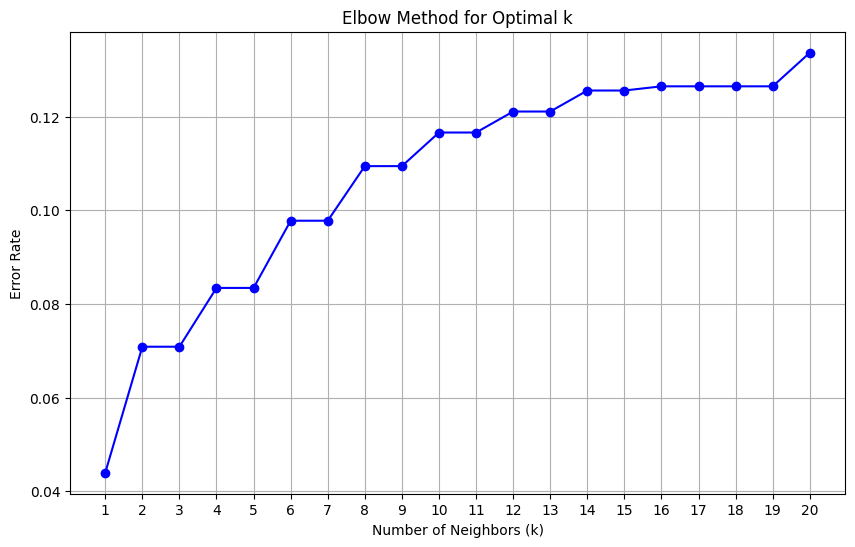

Optimal k (Elbow Method): 1


In [34]:
k_values = range(1, 21)
errors = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    error = 1 - accuracy_score(y_test, y_pred)
    errors.append(error)


plt.figure(figsize=(10, 6))
plt.plot(k_values, errors, marker='o', linestyle='-', color='b')
plt.xticks(k_values)
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Error Rate')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()


optimal_k_elbow = k_values[np.argmin(errors)]
print(f"Optimal k (Elbow Method): {optimal_k_elbow}")


In [35]:
# تنظیمات Grid Search
param_grid = {'n_neighbors': range(1, 21)}
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# بهترین مقدار k
optimal_k_grid = grid_search.best_params_['n_neighbors']
print(f"Optimal k (Grid Search): {optimal_k_grid}")


Optimal k (Grid Search): 1


Final Model Accuracy: 0.9560538116591928
Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.98       965
           1       0.98      0.69      0.81       150

    accuracy                           0.96      1115
   macro avg       0.97      0.84      0.89      1115
weighted avg       0.96      0.96      0.95      1115



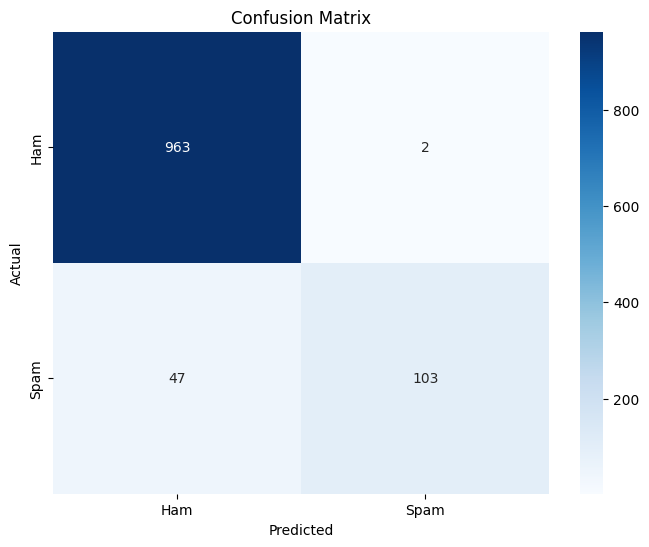

In [36]:
# انتخاب بهترین k از Grid Search
final_k = optimal_k_grid

# اجرای مدل نهایی
final_knn = KNeighborsClassifier(n_neighbors=final_k, weights='distance')
final_knn.fit(X_train, y_train)

# پیش‌بینی و ارزیابی
y_pred = final_knn.predict(X_test)
print("Final Model Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# ماتریس درهم‌ریختگی
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


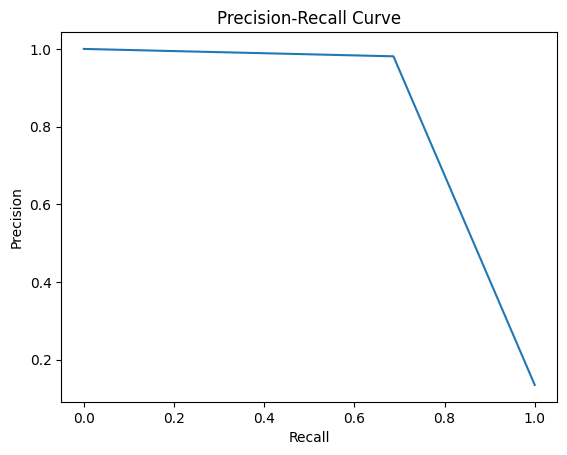

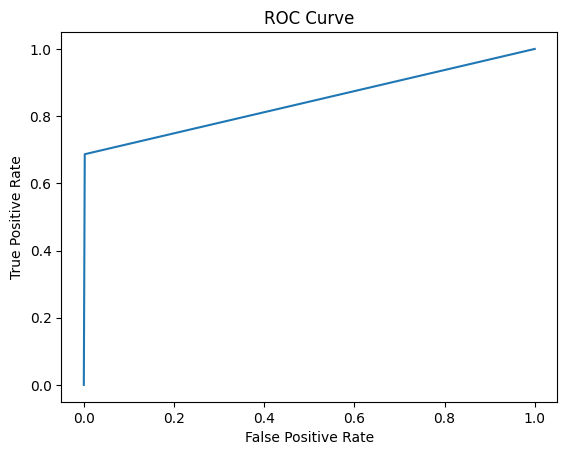

In [37]:
# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, final_knn.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
